In [ ]:
# 전역 변수 설정
VOCAB_SIZE = 44851  # 단어 사전 크기
MAX_LEN = 447       # 패딩할 최대 문장 길이
EMBEDDING_DIM = 128

CSV_PATH = '/content/drive/MyDrive/ml_project/imdb.csv' # 원본 데이터 경로

VECTORIZER_PATH = '/content/drive/MyDrive/ml_project/vectorizer_layer_model_1109.keras' # 토크나이저 저장 경로
PREPROCESSED_PATH = '/content/drive/MyDrive/ml_project/imdb_preprocessed.csv' # 전처리된 데이터 저장 경로


from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

df = pd.read_csv(CSV_PATH) # https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
print("원본 데이터 로드완료")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
원본 데이터 로드완료


In [ ]:
# HTML 태그 제거
import re
import html # HTML 엔티티 처리를 위해 import

def remove_html_tags_regex(text):
    # 1. HTML 태그 제거: <로 시작해서 >로 끝나는 모든 것을 찾음
    # <.*?> : . (모든 문자)가 * (0번 이상) 반복되는데, ? (non-greedy)
    # ?가 없으면 "text" 전체를 태그로 인식할 수 있음
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern, ' ', text) # 태그를 공백(' ')으로 치환

    # 2. HTML 엔티티 변환 (e.g.,   -> 공백, < -> <)
    cleaned_text = html.unescape(cleaned_text)

    # 3. 여러 개의 공백을 하나로 합침
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

df['review'] = df['review'].apply(remove_html_tags_regex)
print("HTML 태그 제거 완료")

HTML 태그 제거 완료


In [ ]:
import string

def clean_text_remove_punct(text):
    """
    구두점을 완전히 제거하는 버전
    """
    # 소문자 변환
    text = text.lower()

    # 아포스트로피 처리
    # don't -> dont, it's -> its 등
    text = text.replace("'", "")

    # 구두점 제거
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    # 여러 개의 공백을 하나로 합침
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['review'] = df['review'].apply(clean_text_remove_punct)

print("전처리 완료")
df.to_csv(PREPROCESSED_PATH, index=False)
print("전처리된 데이터 저장 경로 : ", PREPROCESSED_PATH)

전처리 완료
전처리된 데이터 저장 경로 :  /content/drive/MyDrive/ml_project/imdb_preprocessed.csv


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization

# 1. TextVectorization 레이어 초기화
vectorize_layer = TextVectorization(
    standardize='lower_and_strip_punctuation', # 1. 소문자 변환, 2. 구두점 제거
    split='whitespace',                        # 3. 띄어쓰기 기준 토큰화
    max_tokens=VOCAB_SIZE,                     # 4. 단어 사전 크기 (OOK 토큰 포함)
    output_mode='int',                         # 5. 정수 인코딩
    output_sequence_length=MAX_LEN             # 6. 패딩 (길이 통일)
)

# 2. 전처리된 텍스트 데이터로 단어 사전(vocabulary) 생성
print("TextVectorization 레이어 어휘 학습(adapt) 시작...")
vectorize_layer.adapt(df['review'])
print("어휘 학습 완료.")

# 3. 레이어를 내보내기(export) 위한 더미 모델 생성
# TextVectorization 레이어만 포함하는 모델을 만듭니다.
model_for_export = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer
])

# 4. 모델 저장 (이 폴더를 압축해서 전달)
model_for_export.save(VECTORIZER_PATH)
print("토크나이저 저장 경로 : ", VECTORIZER_PATH)
# load_model(VECTORIZER_PATH) 을 통해 불러올 수 있습니다.

TextVectorization 레이어 어휘 학습(adapt) 시작...
어휘 학습 완료.
토크나이저 저장 경로 :  /content/drive/MyDrive/ml_project/vectorizer_layer_model_1109.keras


In [ ]:
# 벡터라이저 로드 및 시퀀스 길이 확인
vectorizer = keras.models.load_model(VECTORIZER_PATH)
print("토크나이저 로드 완료")
# seq_len = vectorizer.output_shape[-1] # 447
# print(seq_len)

data = pd.read_csv(PREPROCESSED_PATH)
print("전처리된 데이터 로드 완료")

label_map = {'positive':1, 'negative':0}
y = data['sentiment'].map(label_map).astype('int32').values

# 텍스트 --> 정수 시퀀스 (N, 447)
X = vectorizer(tf.constant(data['review'].tolist()))
X = tf.cast(X, tf.int32)
print('X shape:', X.shape, 'y shape:', y.shape)# --> X shape: (50000, 447) y shape: (50000,)

vocab_size = VOCAB_SIZE
embedding_dim = EMBEDDING_DIM
seq_len = MAX_LEN

print("vocab_size:", vocab_size, "embedding_dim:", embedding_dim, "seq_len:", seq_len)

토크나이저 로드 완료
전처리된 데이터 로드 완료
X shape: (50000, 447) y shape: (50000,)
vocab_size: 44851 embedding_dim: 128 seq_len: 447


In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [ ]:
# ---- 모델 정의 (Functional API) ----
inputs = keras.Input(shape=(seq_len,), dtype="int32")

# Embedding: 정수 시퀀스 -> (batch, seq_len, embedding_dim)
x = layers.Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    mask_zero=True
)(inputs)

# Keras가 자동으로 mask 관리
mask = x._keras_mask   # (batch, seq_len), True/False

# LSTM: 문맥 반영. attention 쓰려고 return_sequences=True
x = layers.Bidirectional(
        layers.LSTM(128, return_sequences=False) # dense layer로 넘기기 위함
    )(x, mask=mask)

# Dense 층: 분류기
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 447)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 447, 128)  │  5,740,928 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 447)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    263,168 │ embedding_1[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,020,609 (22.97 MB)

 Trainable params: 6,020,609 (22.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# 0) 텐서를 넘파이로 변환
X_all = X.numpy()   # X: (50000, 447) tf.Tensor
y_all = y           # y: (50000,)

# 1) data split (train:val:test) = (0.6:0.2:0.2)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)

print("train:", X_train.shape,
      "val:",   X_val.shape,
      "test:",  X_test.shape)

# 3) EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

BATCH_SIZE = 128
EPOCHS = 10

history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

# 4) 최종 test 성능 평가
test_loss, test_acc = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("최종 test loss:", test_loss)
print("최종 test accuracy:", test_acc)

# 5) 모델 저장 (Keras가 추천하는 .keras 포맷)
MODEL_PATH = '/content/drive/MyDrive/ml_project/model_lstm_1.keras'
model.save(MODEL_PATH)
print("모델 저장 완료:", MODEL_PATH)


train: (30000, 447) val: (10000, 447) test: (10000, 447)
Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 818s 3s/step - accuracy: 0.6810 - loss: 0.5938 - val_accuracy: 0.8763 - val_loss: 0.3029
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 808s 3s/step - accuracy: 0.9248 - loss: 0.2039 - val_accuracy: 0.8861 - val_loss: 0.2885
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 859s 3s/step - accuracy: 0.9703 - loss: 0.0927 - val_accuracy: 0.8870 - val_loss: 0.3860
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 807s 3s/step - accuracy: 0.9865 - loss: 0.0431 - val_accuracy: 0.8840 - val_loss: 0.4294
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 826s 4s/step - accuracy: 0.9909 - loss: 0.0261 - val_accuracy: 0.8846 - val_loss: 0.6567
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 857s 3s/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.8769 - val_loss: 0.6418
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 827s 4s/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.8769 - val_loss: 0.8569
79/79 ━━━━━━━━━━━━━━━━━━━━ 74s 931ms/ste

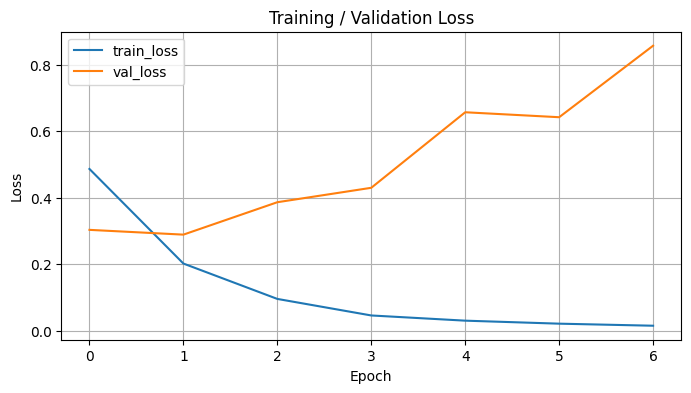

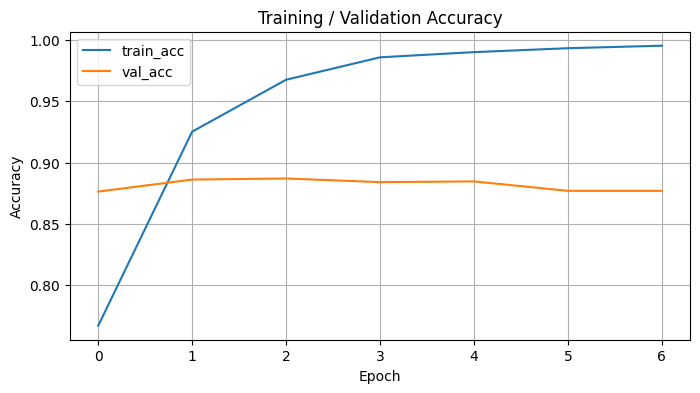

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = history.history

    # 1) Loss
    plt.figure(figsize=(8, 4))
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training / Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2) Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(hist['accuracy'], label='train_acc')
    plt.plot(hist['val_accuracy'], label='val_acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training / Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)